# Import packages and define functions

In [1]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# Feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

# Variance inflation factor, mean abs/squarred error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [2]:
# creates dictionary of variance inflation factors. 
def create_vif_list(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    return vif_dict

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y,n=1):

    linreg = LinearRegression()
    selector = RFE(linreg,n_features_to_select=n)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y,select_rank=False):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    if select_rank == True:
        return selections
    else:
        return rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict

def create_CC_df(X,minimum=0,maximum=1):

    cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
    cor_df.set_index(['pairs'], inplace = True)
    cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
    cor_df.columns = ['cc']
    cor_df.drop_duplicates(inplace=True)
    cor_df = cor_df[(cor_df.cc>minimum) & (cor_df.cc < maximum)]
    
    return cor_df

def model_strength_indicators(model):
    indicator_dict = {
    'r_squared':model.summary2().tables[0][3][0],
    'skew':model.summary2().tables[2][1][2],
    'kurtosis':model.summary2().tables[2][1][3],
    'Durbin Watson':model.summary2().tables[2][3][0],
    'Jarque-Bera':model.summary2().tables[2][3][1],
    'P value':model.summary2().tables[2][3][2],
    'Condition':model.summary2().tables[2][3][3],
    'Coef. weight': sum(model.summary2().tables[1]['Coef.'][1:])
    }
    return indicator_dict

def p_value_selection(model):
    p_values = model.summary2().tables[1]['P>|t|'][1:] # get series of all features's P values
    low_Ps = p_values.loc[p_values < .05].keys() # get the labels of the features only with P values below 0.05
    return low_Ps


# Import data and prepare for exploration
initial record count is 21597

In [3]:
data = pd.read_csv('data/kc_house_data.csv')
data.drop(data.loc[data['sqft_basement']=='?'].index,inplace=True) # remove '?' from the data.

##### Make object types numerical

In [4]:
# convert all string types into np floats
data.sqft_basement = [float(sq) for sq in list(data.sqft_basement)]


# Replaces grade strings with numerics based on data dict. 
grade_strings = list(data.grade.unique()) # list of unique values from column
grade_nums = [int(grade.split()[0]) for grade in list(data.grade.unique())] # list of corresponding integer type values

# replaces a cell value with the int of the first character of its existing string
data.grade.replace(to_replace=grade_strings,value=grade_nums,inplace=True)


# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
data.condition.replace(to_replace=condition_dict,inplace=True)


# replace yr_built NaNs with numeric 0
data.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)


# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
data.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)


# convert view from string into categorical ordinal
view_dict = {np.nan:0,'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
data.view.replace(to_replace=view_dict,inplace=True)


# convert dates into ordinals, extrapolate month from date into new column. 
data.date = pd.to_datetime(data['date']) # convert date string into datetime object 
data['sale_month'] = data.date.apply(lambda x: x.month) # extropolate month from date into new column
data.date = data['date'].map(dt.datetime.toordinal) # convert original date to ordinal
data.rename({'date':'sale_date'},axis=1,inplace=True) # rename date to 'sale_date' for readability 

In [5]:
# inspect data for any object types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   sale_date      21143 non-null  int64  
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   21143 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

In [6]:
# declare target and predictor variables
y = data.price 
X = data.drop('price',axis=1)

# Create and visualize a baseline

#### First round of feature selection and elimination
- First select features based on P values using a forward-backward stepwise selection. 
- Then perform feature ranking with recursive feature elimination with cross validation.
- Finally eliminate highly colinear features based on variance inflation factor and correlation coefficients.

In [7]:
# stepwise feature elmination
stepwise_selected = stepwise_selection(X,y,verbose=False)
X_base = X[stepwise_selected]

In [8]:
# recursive feature elimination
RFE_selection = run_RFECV(X_base,y)
X_base = X_base[RFE_selection]

In [9]:
# inspecting multicolinearity 

# eliminate features base on variance inflation factor
good,bad = create_vif_list(X_base)
X_base = X_base[good[1:]]


In [10]:
# not eliminating sqft_lot or sqft_lot15because the correlation coefficient is less than .75, I suspect at least one will be weeded out later on anyway. 
cc_df = create_CC_df(X_base,.6,1)
cc_df

,cc
pairs,
"(sqft_living15, grade)",0.713574
"(grade, bathrooms)",0.666493


In [11]:
base_model = run_OLS_model(X_base,y)
base_model_strength = model_strength_indicators(base_model)

In [12]:
# eliminate any remaining features with P values above 0.05
Ps = p_value_selection(base_model)
X_base = X_base[Ps]
base_model = run_OLS_model(X_base,y)
base_resid = base_model.resid

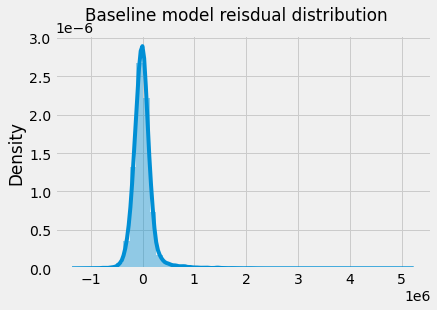

In [13]:
sns.distplot(base_resid)
plt.suptitle("Baseline model reisdual distribution")
plt.show()

In [14]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     2795.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:30:31   Log-Likelihood:            -2.8941e+05
No. Observations:               21143   AIC:                         5.789e+05
Df Residuals:                   21127   BIC:                         5.790e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.761e+07   1.07e+07     -6.336      0.000   -8.85e+07   -4.67e+07
waterfront     6.656e+05   1.94e+04     34.266      0.000    6.28e+05    7.04e+05
floors         1.339e+04   3450.408      3.880      0.000    6625.061    2.02e+04
grade          1.403e+05   2119.347     66.186      0.000    1.36e+05    1.44e+05
yr_built      -3248.3336     75.299    -43.139      0.000   -3395.926   -3100.741
lat            5.754e+05   1.14e+04     50.652      0.000    5.53e+05    5.98e+05
view           5.823e+04   2232.687     26.081      0.000    5.39e+04    6.26e+04
zipcode        -521.7802     35.240    -14.806      0.000    -590.853    -452.707
long          -1.594e+05   1.35e+04    -11.771      0.000   -1.86e+05   -1.33e+05
bathrooms      1.058e+05   2870.821     36.871      0.000       1e+05    1.11e+05
condition      2.788e+04   2504.726     11.130      0.000     2.3e+04    3.28e+04
sale_date       105.0787     13.855      7.584      0.000      77.921     132.236
sqft_living15    89.7493      3.341     26.864      0.000      83.201      96.298
yr_renovated     24.0613      4.267      5.639      0.000      15.698      32.425
sale_month    -1547.2027    501.791     -3.083      0.002   -2530.752    -563.653
id             -1.76e-06    5.1e-07     -3.450      0.001   -2.76e-06    -7.6e-07
==============================================================================
Omnibus:                    20858.917   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3555283.756
Skew:                           4.411   Prob(JB):                         0.00
Kurtosis:                      65.912   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Observations:

Data is clearly not normally distributed. First step is to investigate impact of elimating outliers within the target variable based on the statistical maximum (IQR * 1.5)

In [15]:
std_thresh = data.price.std()*3 # three standard deviations 
std_cap = data.loc[abs(data['price']) <= std_thresh] # slicing all data within the defined range

#re-declare X and y variables
y = std_cap.price
X_outliers = std_cap[X_base.columns]

Inspect resulting model 

In [16]:
# build model and grab residuals
outlier_model = run_OLS_model(X_outliers,y)
Ps = p_value_selection(outlier_model)
X_outliers = X_outliers[Ps]

outlier_model = run_OLS_model(X_outliers,y)
outlier_model_strength = model_strength_indicators(outlier_model)
outlier_model_residual = outlier_model.resid


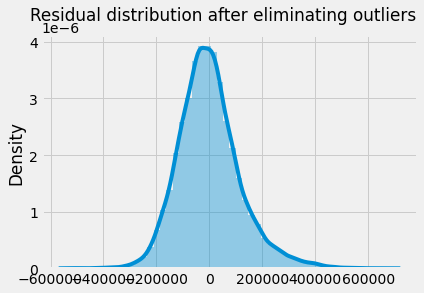

In [17]:
# visualize model residuals
sns.distplot(outlier_model_residual)
plt.suptitle('Residual distribution after eliminating outliers')
plt.show()

In [18]:
outlier_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     3026.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:30:32   Log-Likelihood:            -2.6154e+05
No. Observations:               19982   AIC:                         5.231e+05
Df Residuals:                   19967   BIC:                         5.232e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.499e+07   6.04e+06     -9.107      0.000   -6.68e+07   -4.32e+07
waterfront     1.299e+05   1.73e+04      7.507      0.000     9.6e+04    1.64e+05
floors         3.138e+04   1972.317     15.910      0.000    2.75e+04    3.52e+04
grade          8.715e+04   1261.943     69.062      0.000    8.47e+04    8.96e+04
yr_built      -2059.1495     43.780    -47.034      0.000   -2144.961   -1973.338
lat            5.318e+05   6305.777     84.337      0.000    5.19e+05    5.44e+05
view            3.24e+04   1417.642     22.854      0.000    2.96e+04    3.52e+04
zipcode        -188.1337     19.956     -9.427      0.000    -227.249    -149.018
long          -1.632e+04   7588.850     -2.151      0.031   -3.12e+04   -1449.967
bathrooms        5.2e+04   1690.360     30.765      0.000    4.87e+04    5.53e+04
condition      2.866e+04   1419.437     20.190      0.000    2.59e+04    3.14e+04
sale_date        67.4827      7.841      8.606      0.000      52.113      82.852
sqft_living15    79.5005      1.999     39.780      0.000      75.583      83.418
yr_renovated     17.0712      2.540      6.722      0.000      12.093      22.049
sale_month    -1339.7584    283.300     -4.729      0.000   -1895.051    -784.466
==============================================================================
Omnibus:                     1674.695   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2842.633
Skew:                           0.617   Prob(JB):                         0.00
Kurtosis:                       4.375   Cond. No.                     5.41e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observations: 
- Indicators of normality slightly improved but still needs work.
- skew is close to zero, kurtosis is slightly heavy
- r-squared has improved
- jarque-bera is fairly high
- some signs of multi-colinearity

Next step is to investigate the impact of log transforming the target variable

In [19]:
# create log transformed target variable
y_log = np.log(y)

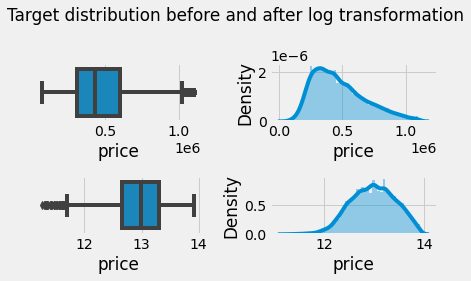

In [20]:
fig,axes = plt.subplots(2,2)

sns.boxplot(y,ax=axes[0,0]) # boxplot before
sns.distplot(y,ax=axes[0,1]) # distplot before

sns.boxplot(y_log,ax=axes[1,0]) # boxplot after
sns.distplot(y_log,ax=axes[1,1]) # boxplot after

fig.suptitle("Target distribution before and after log transformation")
plt.tight_layout()
plt.show()

In [21]:
stepwise_selected = stepwise_selection(X_outliers,y_log,verbose=False)
X_for_log = X_outliers[stepwise_selected]

RFE_selection = run_RFECV(X_for_log,y_log)
X_for_log = X_for_log[RFE_selection]

good,bad = create_vif_list(X_for_log)
X_for_log = X_for_log[good]

log_model = run_OLS_model(X_for_log,y_log)
Ps = p_value_selection(log_model)
X_for_log = X_for_log[Ps]

log_model = run_OLS_model(X_for_log,y_log)
log_model_strength = model_strength_indicators(log_model)
log_model_residuals = log_model.resid

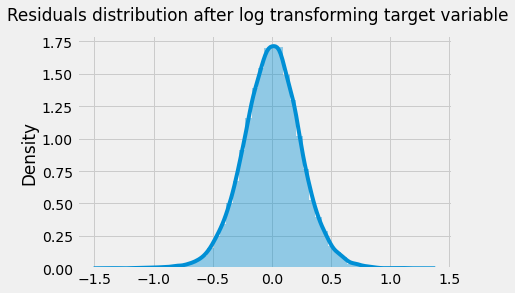

In [22]:
# visualize model residuals
sns.distplot(log_model_residuals)
plt.suptitle('Residuals distribution after log transforming target variable')
plt.show()

In [23]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     3493.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:30:36   Log-Likelihood:                -283.25
No. Observations:               19982   AIC:                             594.5
Df Residuals:                   19968   BIC:                             705.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -128.7803     12.666    -10.167      0.000    -153.608    -103.953
grade             0.1737      0.003     65.984      0.000       0.169       0.179
yr_built         -0.0038   8.95e-05    -42.381      0.000      -0.004      -0.004
lat               1.3421      0.013    101.546      0.000       1.316       1.368
sqft_living15     0.0002   4.07e-06     37.854      0.000       0.000       0.000
bathrooms         0.1233      0.004     34.803      0.000       0.116       0.130
view              0.0622      0.003     20.957      0.000       0.056       0.068
condition         0.0673      0.003     22.597      0.000       0.061       0.073
floors            0.0695      0.004     16.812      0.000       0.061       0.078
sale_date         0.0002   1.64e-05      9.895      0.000       0.000       0.000
zipcode          -0.0004   3.76e-05     -9.900      0.000      -0.000      -0.000
waterfront        0.3029      0.036      8.351      0.000       0.232       0.374
yr_renovated   3.237e-05   5.32e-06      6.081      0.000    2.19e-05    4.28e-05
sale_month       -0.0026      0.001     -4.337      0.000      -0.004      -0.001
==============================================================================
Omnibus:                      344.589   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.479
Skew:                          -0.111   Prob(JB):                    4.56e-138
Kurtosis:                       3.843   Cond. No.                     5.41e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observations: 
- Indicators of normality improved but still needs work.
- skew is close to zero, kurtosis is slightly heavy
- r-squared has improved
- jarque-bera is fairly high, but significantly better
- condition number is unchanged

Next step is another round of new feature engineering

# Engineering new features to further improve the model

- First new features will be engineered by joining IRS data on income by zipcode.
- two categorical variables will be one-hot encoded (waterfront location, and tax bracket)  
- Lastly, new feature may be developed by interpolating existing feature of data. 

Features extrapolated from zipcode

In [24]:
# Dictionary with zipcodes associated with waterfronts described by the data dictionary
water_loc_dict = {'Duwamish':[98168],
'Elliott Bay':[98119,98104,98129,98132,98127,98125,98195,98101,98134,98170,98139,98131,98181], 
'Puget Sound':[98071,98083,98013,98070,98031,98131,98063,98195,98207,98190], 
'Lake Union':[98109], 
'Ship Canal':[00000], 
'Lake Washington':[98072,98077], 
'Lake Sammamish':[98074,98075,98029], 
'other lake':[00000], 
'river/slough waterfronts':[00000]}

# list to contain new column data
waterfront_list = []

# for loop to assign waterfront based on zipcode
for zipcode in X_outliers.zipcode:
    for k,v in water_loc_dict.items():
        if zipcode in v:
            waterfront_list.append(k)
            appended = True
            break
        else: 
            appended = False
    if not appended:
        waterfront_list.append('NONE')

# print(len(waterfront_list),set(waterfront_list))
X_outliers['waterfront_loc'] = waterfront_list
X_for_log['waterfront_loc'] = waterfront_list

features interpolated from external data

In [25]:
# IRS income tax data from data.world 
# https://data.world/jonloyens/irs-income-by-zip-code/workspace/query?queryid=0491f7ff-f7e5-49be-ad8c-8047d6a54c57

income = pd.read_csv('data/irs_income_by_zipcode.csv')

income.avg_taxable_income = income.avg_taxable_income*1000 # scaling data back to dollar units (was in thousands)
income.taxable_income_amount = income.taxable_income_amount*1000 
income.rename({'taxable_income_amount':'zip_tax_revenue'},axis=1,inplace=True) # renaming to something more idiomatic

# # create lists to stage data in order to concat new columns later
joint_filing_bracket = [] #for the joint filing tax schedule

# there is probably a more "pythony" way to do this for loop but it works so I'm not touching it 
for average in income.avg_taxable_income:
    if average > 628301:
        joint_filing_bracket.append(7)
    elif average <= 19900:
        joint_filing_bracket.append(1)
    elif (average >= 19901) and (average <= 81050):
        joint_filing_bracket.append(2)
    elif (average >= 81051) and (average <= 172750):
        joint_filing_bracket.append(3)
    elif (average >= 172751) and (average <= 329850):
        joint_filing_bracket.append(4)
    elif (average >= 329851) and (average <= 418850):
        joint_filing_bracket.append(5)
    elif (average >= 418851) and (average <= 628300):
        joint_filing_bracket.append(6)

# assign discovered data to new column
income['joint_filing_tax_bracket'] = joint_filing_bracket

# create dictionary of zipcodes with corresponding tax bracket
# dictionary will be used to assign create similar columns in the principal data.
joint_filing_tax_dict = {}
tax_revenue_dict = {}

# create ditionaries to later assign values to principal data
for row in income.iterrows():
    joint_filing_tax_dict[row[1][0]] = row[1][3]
    tax_revenue_dict[row[1][0]] = row[1][1]

# concat columns to X containing tax bracket based on single and joint filing federal income tax schedule
X_outliers['income_tax_bracket'] = X.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X_outliers['zip_tax_revenue'] = X.zipcode.replace(to_replace=tax_revenue_dict)

X_for_log['income_tax_bracket'] = X.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X_for_log['zip_tax_revenue'] = X.zipcode.replace(to_replace=tax_revenue_dict)


In [26]:
# create dummy variables
waterfront_dummies = pd.get_dummies(X_outliers.waterfront_loc,prefix='waterfront',prefix_sep='_').drop('waterfront_NONE',axis=1)
bracket_dummies = pd.get_dummies(X_outliers.income_tax_bracket,drop_first=True,prefix='income_tax',prefix_sep='_')
sale_month_dummies = pd.get_dummies(X_outliers.sale_month,prefix='sale_month',prefix_sep='_',drop_first=True)

# reasign X to concatenated dataframe, dropping features no longer needed
X_outliers = X_outliers.drop(['waterfront_loc','zipcode'],axis=1)
X_outliers = pd.concat([X_outliers,bracket_dummies,waterfront_dummies,sale_month_dummies],axis=1)

X_for_log = X_for_log.drop(['waterfront_loc','zipcode'],axis=1)
X_for_log = pd.concat([X_for_log,bracket_dummies,waterfront_dummies,sale_month_dummies],axis=1)

### create baseline for engineered features

In [27]:
pre_hot_base = run_OLS_model(X_outliers,y) # some high p values
Ps = p_value_selection(pre_hot_base)
X_hot = X_outliers[Ps] 
hot_base_model = run_OLS_model(X_hot,y)
hot_base_model_stregnth = model_strength_indicators(hot_base_model)
hot_base_model_residuals = hot_base_model.resid

X_hot_log = X_for_log
hot_log_model = run_OLS_model(X_for_log,y_log)
hot_log_model_stregnth = model_strength_indicators(hot_log_model)
hot_log_model_residuals = hot_log_model.resid


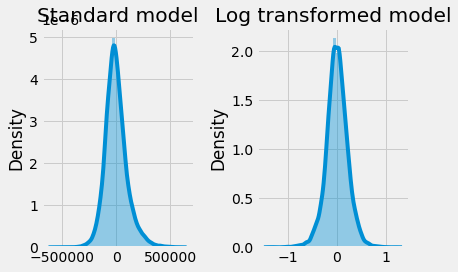

In [28]:
fig, axes = plt.subplots(1,2)
hb = sns.distplot(hot_base_model_residuals,ax=axes[0]).set_title('Standard model')
hl = sns.distplot(hot_log_model_residuals,ax=axes[1]).set_title('Log transformed model')

fig.tight_layout()
plt.show()

Continue to rank, select and eliminate features. 

In [29]:
# for the non-transformed model
stepwise_selections = stepwise_selection(X_hot,y,verbose=False)
X_hot = X_hot[stepwise_selections]

rfecv_selections = run_RFECV(X_hot,y)
X_hot = X_hot[rfecv_selections]

good,bad = create_vif_list(X_hot)
X_hot = X_hot[good[1:]]

In [30]:
# for the log transformed model
stepwise_selections = stepwise_selection(X_hot_log,y_log,verbose=False)
X_hot_log = X_hot_log[stepwise_selections]

rfecv_selections = run_RFECV(X_hot_log,y_log)
X_hot_log = X_hot_log[rfecv_selections]

good,bad = create_vif_list(X_hot_log)
X_hot_log = X_hot_log[good[1:]]

In [31]:
hot_base_model_filtered = run_OLS_model(X_hot,y_log)
hot_base_model_filtered_strength = model_strength_indicators(hot_base_model_filtered)
hot_base_model_filtered_resid = hot_base_model_filtered.resid

hot_log_model_filtered = run_OLS_model(X_hot_log,y_log)
hot_log_model_filtered_strength = model_strength_indicators(hot_log_model_filtered)
hot_log_model_filtered_resid = hot_log_model_filtered.resid


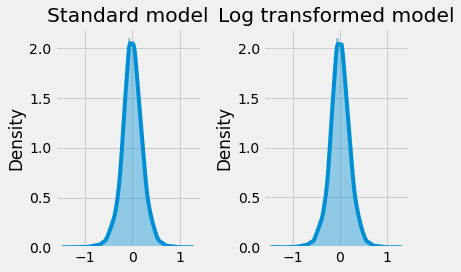

In [32]:
fig, axes = plt.subplots(1,2)
hb = sns.distplot(hot_base_model_filtered_resid,ax=axes[0]).set_title('Standard model')
hl = sns.distplot(hot_log_model_filtered_resid,ax=axes[1]).set_title('Log transformed model')

fig.tight_layout()
plt.show()

Continue eliminating features manually to address remaining multi-colinearity and further fit the model 

In [33]:
vif_dict = create_vif_dictionary(X_outliers)
low_vifs = [k for k,v in vif_dict.items() if v < 2.5][1:]
X_new = X_outliers[low_vifs]

# deal with resulting high p values 
new_base_model = run_OLS_model(X_new,y)
Ps = p_value_selection(new_base_model)
X_new = X_new[Ps]

# finalize model
new_base_model = run_OLS_model(X_new,y)
new_base_model_strength = model_strength_indicators(new_base_model)
new_base_model_residuals = new_base_model.resid

In [34]:
vif_dict = create_vif_dictionary(X_hot_log)
low_vifs = [k for k,v in vif_dict.items() if v < 2.5][1:]
X_new_log = X_hot_log[low_vifs]

# deal with resulting high p values 
new_log_model = run_OLS_model(X_new_log,y_log)
Ps = p_value_selection(new_log_model)
X_new_log = X_new_log[Ps]

# finalize model
new_log_model = run_OLS_model(X_new_log,y_log)
new_log_model_strength = model_strength_indicators(new_log_model)
new_log_model_residuals = new_base_model.resid

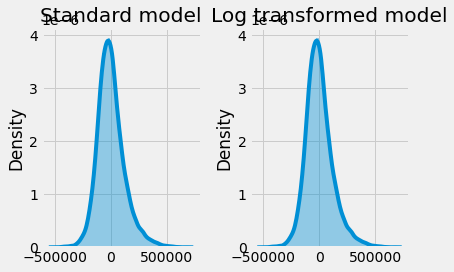

In [35]:
fig, axes = plt.subplots(1,2)
hb = sns.distplot(new_base_model_residuals,ax=axes[0]).set_title('Standard model')
hl = sns.distplot(new_log_model_residuals,ax=axes[1]).set_title('Log transformed model')

fig.tight_layout()
plt.show()

# Review model performance across iterations
Features are ranked, selected and eliminated through each iteration using the same selection pattern: first selection and elimination based on p-value using a forward-backward stepwise selection method, second selction and elimination based on feature "importance" using recursive feature elimination with cross validation. third selection and elimination based on multi-colinearity determined first by variance inflation factor and second using colinearity coefficients.

Baseline model strength after firs round of feature selection and elimination

In [36]:
simple_strengths_list = [base_model_strength,outlier_model_strength,log_model_strength] # models before new feature engineering
simple_strengths_ticks = ['base_model','outlier_model','log_model']
simple_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in simple_strengths_list],
'skews':[float(strength['skew']) for strength in simple_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in simple_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in simple_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in simple_strengths_list],
'P values':[float(strength['P value']) for strength in simple_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in simple_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in simple_strengths_list]
}

clever_strengths_list = [hot_base_model_filtered_strength,hot_base_model_filtered_strength,new_base_model_strength]
clever_strengths_ticks =['hot_model','hot_model_filtered','new_model']
clever_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in clever_strengths_list],
'skews':[float(strength['skew']) for strength in clever_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in clever_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in clever_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in clever_strengths_list],
'P values':[float(strength['P value']) for strength in clever_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in clever_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in clever_strengths_list]
}

clever_log_strengths_list = [hot_log_model_filtered_strength,hot_log_model_filtered_strength,new_log_model_strength]
clever_log_ticks = ['hot_log_model','hot_log_model_filtered','new_log_model']
clever_log_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in clever_log_strengths_list],
'skews':[float(strength['skew']) for strength in clever_log_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in clever_log_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in clever_log_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in clever_log_strengths_list],
'P values':[float(strength['P value']) for strength in clever_log_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in clever_log_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in clever_log_strengths_list]
}


all_base_strenghts_list = [base_model_strength,outlier_model_strength,log_model_strength,hot_base_model_filtered_strength,hot_base_model_filtered_strength,new_base_model_strength]
all_base_strengths_ticks = simple_strengths_ticks + clever_strengths_ticks
all_base_strenghts_dict ={
'r_squares':[float(strength['r_squared']) for strength in all_base_strenghts_list],
'skews':[float(strength['skew']) for strength in all_base_strenghts_list],
'kurtoses':[float(strength['kurtosis']) for strength in all_base_strenghts_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in all_base_strenghts_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in all_base_strenghts_list],
'P values':[float(strength['P value']) for strength in all_base_strenghts_list],
'Condition numbers':[int(strength['Condition']) for strength in all_base_strenghts_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in all_base_strenghts_list]
}

base_plus_log_list = [base_model_strength,outlier_model_strength,log_model_strength,hot_log_model_filtered_strength,hot_log_model_filtered_strength,new_log_model_strength]
base_plus_log_ticks = simple_strengths_ticks + clever_log_ticks
base_plus_log_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in base_plus_log_list],
'skews':[float(strength['skew']) for strength in base_plus_log_list],
'kurtoses':[float(strength['kurtosis']) for strength in base_plus_log_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in base_plus_log_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in base_plus_log_list],
'P values':[float(strength['P value']) for strength in base_plus_log_list],
'Condition numbers':[int(strength['Condition']) for strength in base_plus_log_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in base_plus_log_list]
}


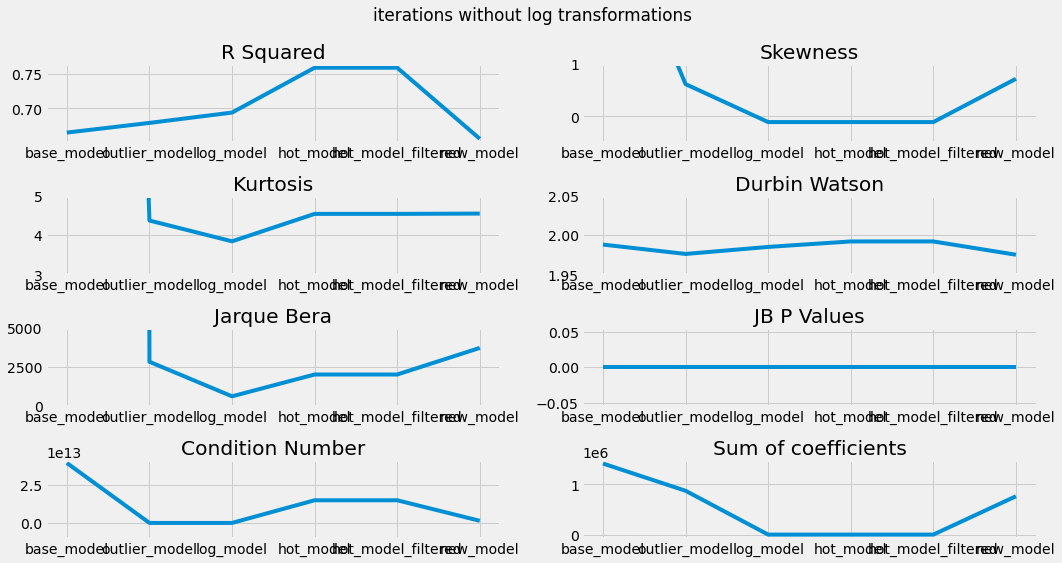

In [37]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.suptitle('iterations without log transformations')
fig.tight_layout()
plt.show()

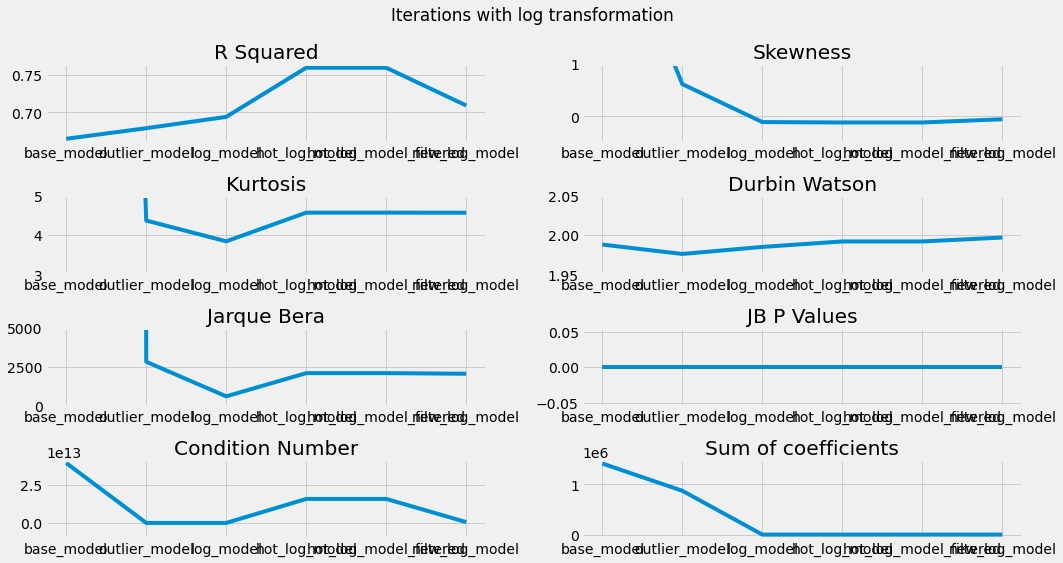

In [38]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.suptitle('Iterations with log transformation')
fig.tight_layout()
plt.show()

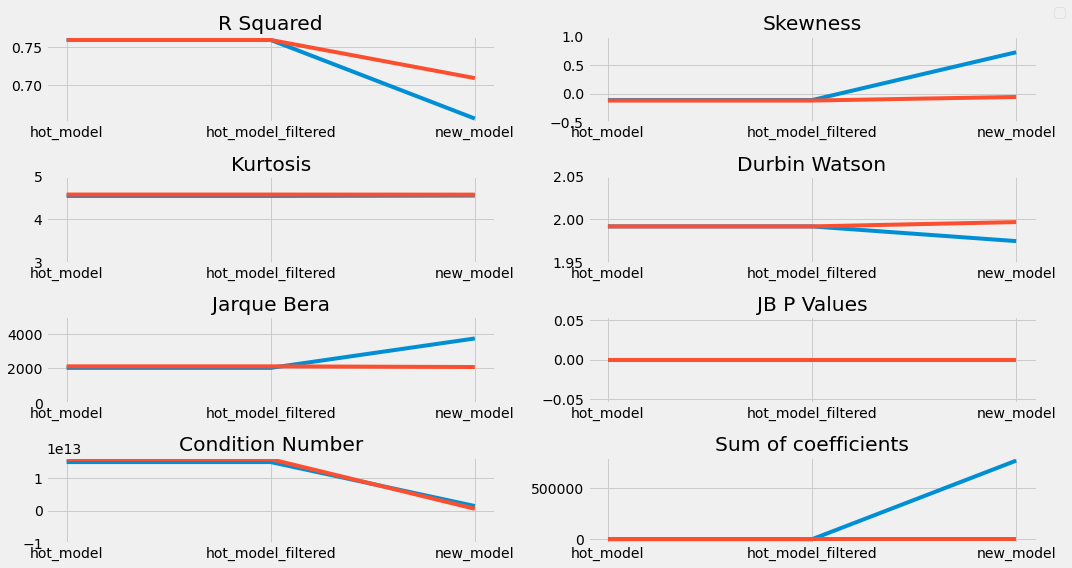

In [39]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
r_sq_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')

sk = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
sk_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)

kt = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
kt_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)

db = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
db_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)

jb = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
jb_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)

pv = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
pv_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')

cn = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
cn_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)

cf = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
cf_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.tight_layout()
fig.legend((r_sq,r_sq_l),('Not transformed','log transformed'))
plt.show()

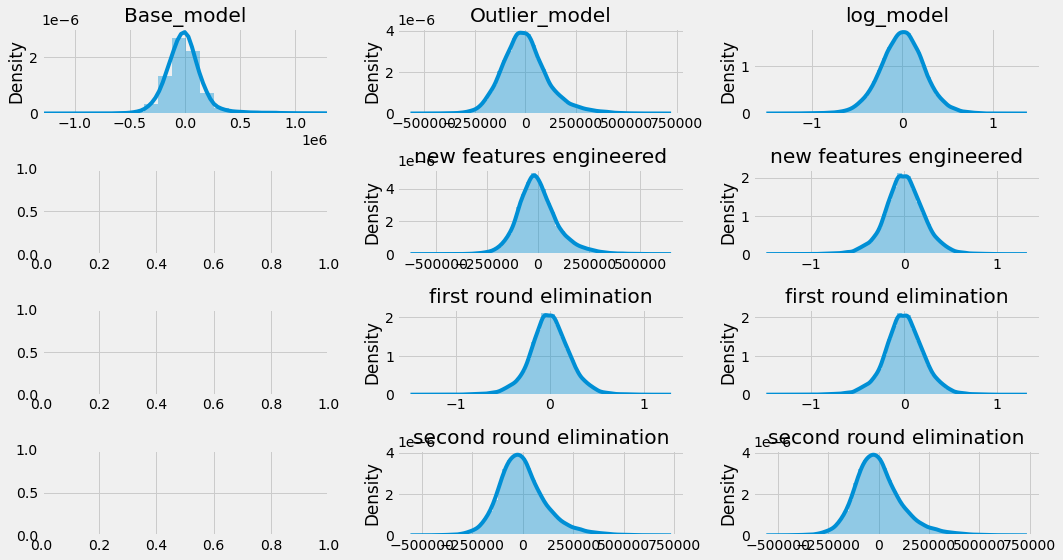

In [40]:
fig, axes = plt.subplots(4,3)

bs = sns.distplot(base_resid,ax=axes[0,0]).set_title('Base_model')
axes[0,0].set_xlim(-1300000,1300000)

ot = sns.distplot(outlier_model_residual,ax=axes[0,1]).set_title('Outlier_model')

lm = sns.distplot(log_model_residuals,ax=axes[0,2]).set_title("log_model")

bl = sns.distplot(hot_base_model_residuals,ax=axes[1,1]).set_title('new features engineered')
bl_l = sns.distplot(hot_log_model_residuals,ax=axes[1,2]).set_title('new features engineered')
# axes[1,0].set_xlim(-50000,50000)

lm = sns.distplot(hot_base_model_filtered_resid,ax=axes[2,1]).set_title('first round elimination')
lm_l = sns.distplot(hot_log_model_filtered_resid,ax=axes[2,2]).set_title('first round elimination')

hm = sns.distplot(new_base_model_residuals,ax=axes[3,1]).set_title('second round elimination')
hm_l = sns.distplot(new_log_model_residuals,ax=axes[3,2]).set_title('second round elimination')


plt.gcf().set_size_inches(15, 8)
fig.tight_layout()
plt.show()

Due to the size of the data set, in this instance the Q-Q plot is not a very useful tool for determining how well the model satisfies the assumption of normality, however the figure below does clearly show how the log transformation on the target variable significantly improved the model at the begining of the iterative process

# Model validation

In [41]:
# create a train and a test split
X_train, X_test, y_train, y_test = train_test_split(X_for_log, y_log, test_size=0.2)

# generate predictions based on test and train sampels
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate train and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

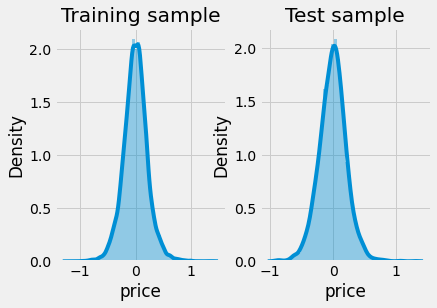

<Figure size 1440x1440 with 0 Axes>

In [42]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.distplot(train_residuals,ax=ax1)
ax1.set_title('Training sample')
sns.distplot(test_residuals,ax=ax2)
ax2.set_title('Test sample')

plt.figure(figsize=(20,20))
plt.show()


In [43]:
# calculate train and test mean squared error 
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', round(train_mse,3))
print('Test Mean Squarred Error:', round(test_mse,3))
print('Difference: ', round(abs(train_mse - test_mse),3))

Train Mean Squarred Error: 0.047
Test Mean Squarred Error: 0.047
Difference:  0.0


In [44]:
cv_5_results  = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=20, scoring='neg_mean_squared_error'))

print('Five k-fold MSE: ', round(cv_5_results,3))
print('Ten k-fold MSE: ', round(cv_10_results,3))
print('Twenty k-fold MSE: ', round(cv_20_results,3))


Five k-fold MSE:  -0.048
Ten k-fold MSE:  -0.048
Twenty k-fold MSE:  -0.048


#### observations on model validation
The mean squared error (MSE), a statistic representing the amount of error in a the model (i.e. how well the regression line fits the data), is calculated to be roughly the same using both a simple train-test split and the k-fold cross validation technique. The MSE is close to zero indicating the model fits the data well, and the model probably fits the real population data also. 

# Observations

After much iteration and of feature engineering, selection and transformation. The strongest model appears to be the strongest model, and the train-test sampling gives me confidence that this iteration of the model fits the population data fairly well in addition to the sample we have available here. I suspected the model would be strengthened by extrapolating certain features into new features (e.g. one hot encoding, joining tax data from a compatible data set) however that was not the case, the problem is that the zipcode feature is essentially un-interpretable due to the fact that it is both categorical and nominal. 

The next steps will be to investigate more granularly how zipcode may be extrapolaed to strengthen the model, and as a lost resort zipcode itself will simply be one-hot encoded. 

In [45]:
# log_model.summary()

### Exploring assigning and one-hot encoding only waterfront locations 

In [46]:
finalist_labels = log_model.summary2().tables[1]['t'].keys()[1:]
X_finals = std_cap.drop('price',axis=1)
X_waters = X_finals[finalist_labels]
X_taxes = X_finals[finalist_labels]

In [47]:
zipcode_dummies = pd.get_dummies(X_finals.zipcode,prefix='zipcode',prefix_sep='_',drop_first=True)

In [67]:
water_model = run_OLS_model(X_waters.drop('zipcode',axis=1),y_log)
water_model_strength = model_strength_indicators(water_model)
water_model_residuals= water_model.resid

water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     1023.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:58:19   Log-Likelihood:                 2992.2
No. Observations:               19982   AIC:                            -5844.
Df Residuals:                   19912   BIC:                            -5291.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -189.1788     10.364    -18.254      0.000    -209.492    -168.865
bathrooms         0.0979      0.003     33.775      0.000       0.092       0.104
lat               1.5680      0.021     73.788      0.000       1.526       1.610
grade             0.1291      0.002     57.062      0.000       0.125       0.133
sqft_living15     0.0002   3.64e-06     45.722      0.000       0.000       0.000
condition         0.0777      0.002     31.611      0.000       0.073       0.083
view              0.0615      0.003     23.869      0.000       0.056       0.067
zipcode_98155    -0.3381      0.011    -30.086      0.000      -0.360      -0.316
zipcode_98133    -0.2966      0.011    -27.984      0.000      -0.317      -0.276
zipcode_98028    -0.3474      0.014    -25.570      0.000      -0.374      -0.321
zipcode_98004     0.4674      0.017     26.881      0.000       0.433       0.501
zipcode_98019    -0.3733      0.016    -23.354      0.000      -0.405      -0.342
zipcode_98072    -0.2587      0.014    -18.531      0.000      -0.286      -0.231
zipcode_98077    -0.2622      0.016    -16.125      0.000      -0.294      -0.230
zipcode_98125    -0.1481      0.011    -12.999      0.000      -0.170      -0.126
zipcode_98177    -0.1649      0.015    -11.255      0.000      -0.194      -0.136
zipcode_98022     0.1776      0.016     10.795      0.000       0.145       0.210
zipcode_98168    -0.2493      0.014    -18.269      0.000      -0.276      -0.223
zipcode_98040     0.3534      0.017     20.668      0.000       0.320       0.387
zipcode_98178    -0.2062      0.014    -15.005      0.000      -0.233      -0.179
zipcode_98052    -0.0246      0.010     -2.499      0.012      -0.044      -0.005
zipcode_98112     0.3584      0.017     21.256      0.000       0.325       0.391
zipcode_98116     0.2441      0.013     19.419      0.000       0.220       0.269
sale_date         0.0002    1.4e-05     12.217      0.000       0.000       0.000
zipcode_98053    -0.0243      0.012     -2.088      0.037      -0.047      -0.001
zipcode_98010     0.2090      0.022      9.468      0.000       0.166       0.252
zipcode_98070     0.1848      0.021      8.881      0.000       0.144       0.226
zipcode_98136     0.2147      0.014     15.513      0.000       0.188       0.242
zipcode_98106    -0.1124      0.012     -9.235      0.000      -0.136      -0.089
zipcode_98055    -0.1682      0.014    -12.280      0.000      -0.195      -0.141
zipcode_98074    -0.0066      0.011     -0.601      0.548      -0.028       0.015
waterfront        0.3537      0.032     11.157      0.000       0.292       0.416
zipcode_98119     0.2987      0.018     16.781      0.000       0.264       0.334
zipcode_98058    -0.1140      0.011    -10.357      0.000      -0.136      -0.092
zipcode_98108    -0.1011      0.016     -6.371   

In [49]:
X_hot_waters = pd.concat([X_waters,waterfront_dummies],axis=1)
X_hot_waters = X_waters.drop('zipcode',axis=1)

In [50]:
stepwise_selections = stepwise_selection(X_hot_waters,y_log,verbose=False)
X_hot_waters = X_hot_waters[stepwise_selections]

recursive_selections = run_RFECV(X_hot_waters,y_log)
X_hot_waters = X_hot_waters[recursive_selections]

In [51]:
vif_dict = create_vif_dictionary(X_hot_waters)
vif_dict

{'const': 48816586.30449014,
 'grade': 2.4552692045540425,
 'yr_built': 2.105888436473027,
 'lat': 1.086365345092668,
 'sqft_living15': 1.9632180994545263,
 'bathrooms': 2.091728567411269,
 'view': 1.1591924436312415,
 'condition': 1.2113508318209052,
 'floors': 1.6122510623468451,
 'sale_date': 1.1441381714673102,
 'waterfront': 1.088837707191057,
 'yr_renovated': 1.1008419450320759,
 'sale_month': 1.1372970354369043}

In [68]:
# yr_built and yr_renovated, when dropped reduce the r squared from .693 to .674 
# but also reduce Jarque Bera significantly (i.e. an improvement) 
# as well as bring the skew the closest to three than any other model in this notebook 

hot_water_model = run_OLS_model(X_hot_waters.drop(['yr_renovated','yr_built'],axis=1),y_log)
hot_water_strength = model_strength_indicators(hot_water_model)
hot_water_residuals = hot_water_model.resid

hot_water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     3907.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:58:44   Log-Likelihood:                -1301.7
No. Observations:               19982   AIC:                             2625.
Df Residuals:                   19971   BIC:                             2712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -173.5974     12.761    -13.604      0.000    -198.610    -148.585
grade             0.1525      0.003     56.012      0.000       0.147       0.158
lat               1.4492      0.013    110.947      0.000       1.424       1.475
sqft_living15     0.0002   4.17e-06     37.890      0.000       0.000       0.000
bathrooms         0.0830      0.004     23.364      0.000       0.076       0.090
view              0.0783      0.003     25.615      0.000       0.072       0.084
condition         0.1044      0.003     35.305      0.000       0.099       0.110
floors            0.0226      0.004      5.378      0.000       0.014       0.031
sale_date         0.0002   1.73e-05      9.088      0.000       0.000       0.000
waterfront        0.3164      0.038      8.297      0.000       0.242       0.391
sale_month       -0.0024      0.001     -3.888      0.000      -0.004      -0.001
==============================================================================
Omnibus:                      171.492   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.415
Skew:                           0.062   Prob(JB):                     2.32e-58
Kurtosis:                       3.551   Cond. No.                     5.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

investigate effect of including one-hot encoded zipcodes

In [53]:
# wasted 3 whole minuts of my life running this cell, Jarque Bera and Kurtosis both increased dramatically. 

X_waters = pd.concat([X_waters.drop(['yr_renovated','yr_built'],axis=1),zipcode_dummies],axis=1)

stepwise_selections = stepwise_selection(X_waters,y_log,verbose=False)
X_waters = X_waters[stepwise_selections]

recursive_selections = run_RFECV(X_waters,y_log)
X_waters = X_waters[recursive_selections]


hot_zip_water_model = run_OLS_model(X_waters,y_log)
hot_zip_water_model_strength = model_strength_indicators(hot_zip_water_model)

hot_zip_water_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1161.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:36:30   Log-Likelihood:                 4106.4
No. Observations:               19982   AIC:                            -8071.
Df Residuals:                   19911   BIC:                            -7510.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -553.2859     12.350    -44.802      0.000    -577.492    -529.080
bathrooms         0.1068      0.003     38.890      0.000       0.101       0.112
lat               0.8863      0.025     36.129      0.000       0.838       0.934
grade             0.1230      0.002     57.405      0.000       0.119       0.127
sqft_living15     0.0002   3.47e-06     53.391      0.000       0.000       0.000
condition         0.0715      0.002     30.704      0.000       0.067       0.076
view              0.0567      0.002     23.237      0.000       0.052       0.061
zipcode_98155    -0.5886      0.012    -49.800      0.000      -0.612      -0.565
zipcode_98133    -0.4661      0.011    -43.901      0.000      -0.487      -0.445
zipcode_98028    -0.0959      0.014     -6.921      0.000      -0.123      -0.069
zipcode_98004     0.7139      0.017     41.473      0.000       0.680       0.748
zipcode_98019    -0.0974      0.016     -6.031      0.000      -0.129      -0.066
zipcode_98072    -0.1877      0.013    -14.133      0.000      -0.214      -0.162
zipcode_98077    -0.2160      0.015    -14.017      0.000      -0.246      -0.186
zipcode_98125    -0.3013      0.011    -26.832      0.000      -0.323      -0.279
zipcode_98177    -0.5136      0.016    -32.890      0.000      -0.544      -0.483
zipcode_98022     0.0901      0.016      5.749      0.000       0.059       0.121
zipcode_98168    -0.7314      0.016    -44.883      0.000      -0.763      -0.699
zipcode_98040     0.4202      0.016     25.890      0.000       0.388       0.452
zipcode_98178    -0.7230      0.017    -43.007      0.000      -0.756      -0.690
zipcode_98052     0.0799      0.010      8.353      0.000       0.061       0.099
zipcode_98112     0.2010      0.016     12.348      0.000       0.169       0.233
zipcode_98116     0.0341      0.013      2.697      0.007       0.009       0.059
sale_date         0.0002   1.32e-05     13.492      0.000       0.000       0.000
zipcode_98053     0.0740      0.011      6.608      0.000       0.052       0.096
zipcode_98010     0.2481      0.021     11.874      0.000       0.207       0.289
zipcode_98070     0.0502      0.020      2.524      0.012       0.011       0.089
zipcode_98136    -0.0996      0.015     -6.817      0.000      -0.128      -0.071
zipcode_98106    -0.3107      0.012    -25.425      0.000      -0.335      -0.287
zipcode_98055    -0.2231      0.013    -17.163      0.000      -0.249      -0.198
zipcode_98074    -0.0289      0.010     -2.758      0.006      -0.049      -0.008
waterfront        0.3617      0.030     12.063      0.000       0.303       0.421
zipcode_98119     0.1237      0.017      7.181      0.000       0.090       0.157
zipcode_98058    -0.1906      0.011    -18.100      0.000      -0.211      -0.170
zipcode_98108    -0.3014      0.016    -19.358   

Visualize iterations 

In [54]:
water_strengths_list = [log_model_strength,water_model_strength,hot_water_strength,hot_zip_water_model_strength]

water_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in water_strengths_list],
'skews':[float(strength['skew']) for strength in water_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in water_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in water_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in water_strengths_list],
'P values':[float(strength['P value']) for strength in water_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in water_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in water_strengths_list]
}

water_strengths_tick_list = ['log_model','water_model','hot_water_model','hot_zip_water']

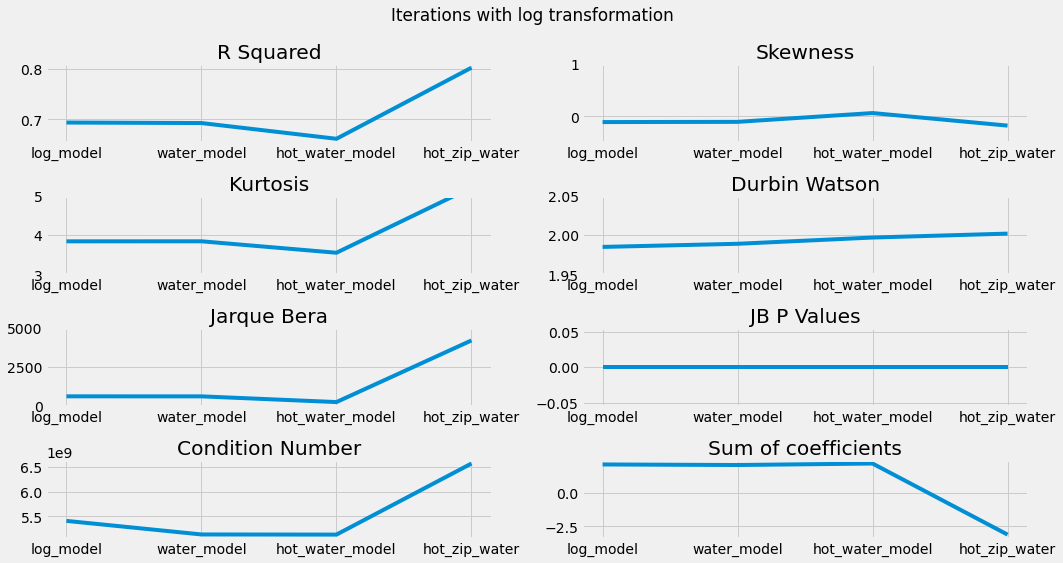

In [55]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
# axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.suptitle('Iterations with log transformation')
fig.tight_layout()
plt.show()

The above visualization demonstrates that hot_water_model, the model including one-hot enocding waterfront locations but not the zipcodes themselves nor and tax info, is the most reliable model. 

### Exploring tax bracket and revenue by zipcode

In [ ]:
X_taxes['income_tax_bracket'] = X_taxes.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X_taxes['zip_tax_revenue'] = X_taxes.zipcode.replace(to_replace=tax_revenue_dict)

# bracket_dummies = pd.get_dummies(X_taxes.income_tax_bracket,prefix='tax_bracket',prefix_sep='_',drop_first=True)
# X_taxes = X_taxes.drop('zipcode',axis=1)

In [ ]:
tax_model = run_OLS_model(X_taxes,y_log)
tax_model.summary()

Trying one-hot encoding tax bracket

In [ ]:
X_taxes = pd.concat([X_taxes,bracket_dummies],axis=1)
X_taxes = X_taxes.drop('zipcode',axis=1)

In [ ]:
stepwise_selections = stepwise_selection(X_taxes,y_log,verbose=False)
X_taxes = X_taxes[stepwise_selections]

recursive_selections = run_RFECV(X_taxes,y_log)
X_taxes = X_taxes[recursive_selections]

In [ ]:
hot_tax_model = run_OLS_model(X_taxes,y_log)

In [ ]:
tax_model.summary()

observations: including tax bracket or tax revenue data tends to weaken the model and is not worth including.

Will not consider including tax data, will validate hot_water_model using multiple train-test splits.

In [56]:
# create a train and a test split
X_train, X_test, y_train, y_test = train_test_split(X_hot_waters, y_log, test_size=0.2)

# generate predictions based on test and train sampels
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate train and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [57]:
# calculate train and test mean squared error 
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', round(train_mse,3))
print('Test Mean Squarred Error:', round(test_mse,3))
print('Difference: ', round(abs(train_mse - test_mse),3))

Train Mean Squarred Error: 0.06
Test Mean Squarred Error: 0.062
Difference:  0.001


In [58]:
cv_5_results  = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=20, scoring='neg_mean_squared_error'))

print('Five k-fold MSE: ', round(cv_5_results,3))
print('Ten k-fold MSE: ', round(cv_10_results,3))
print('Twenty k-fold MSE: ', round(cv_20_results,3))

Five k-fold MSE:  -0.048
Ten k-fold MSE:  -0.048
Twenty k-fold MSE:  -0.048


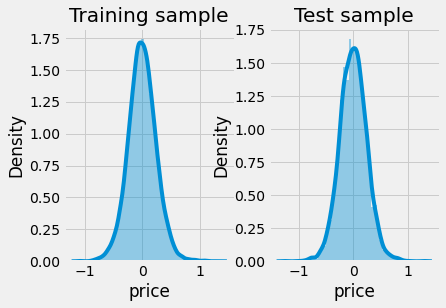

<Figure size 1440x1440 with 0 Axes>

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.distplot(train_residuals,ax=ax1)
ax1.set_title('Training sample')
sns.distplot(test_residuals,ax=ax2)
ax2.set_title('Test sample')

plt.figure(figsize=(20,20))
plt.show()

The simple train-test split as well as usingthe k-fold technique show virtually no difference in the mean-squared error of the test and training samples, aslo the MSE itself is nearly zero but not exactly zero. This indicates that this model is appropriately fitted to the data used in this notebook and probably fits the analogous population data well also. I feel confident that this model is reliable and can be used with confidence to make decisions for the business.  

# Final Observations

After a robust and extensive iterative process the model name "hot_water_model" is the strongest and most reliable model found in throughout the exploratory process within this notebook. By sheer value the condition number and Jarque Bera are far from zero, which is normally interpreted as an indication that the data is not normally distributed. However, when compared to earlier iterations of the model the final condition number, Jarque Bera as well as other indicators of normality are nearly exactly where they should be when viewed *at scale*. Also, the distribution of the model residual visaully appear to be very normal. 

it became clear that some of the inferred features (waterfront locations, tax brackets, etc.) were weakening the model, grouping these features qualitatively and examining how each of the groups affected the model on their own, it was obvious that any tax data should not be included but waterfront locations (one-hot included) were definitely worth including in the final model.

Ultimately the final model is the result of eliminating outliers (where the target variable is greater than 3 standard deviations from its mean), log-transforming the target variable, and extrapolating waterfront locations based on zipcode and one-hot encoding that discovered cartegorical data. While selecting, ranking and eliminating features based on P value, variance inflation factors, and coeficient magnitude at each of these aformentioned iterations. 

In [77]:
final_strengths_list = [base_model_strength,outlier_model_strength,log_model_strength,water_model_strength,hot_water_strength]

final_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in final_strengths_list],
'skews':[float(strength['skew']) for strength in final_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in final_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in final_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in final_strengths_list],
'P values':[float(strength['P value']) for strength in final_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in final_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in final_strengths_list]
}

final_strengths_tick_list = ['baseline','outlier\nelimination','log\ntransformation','feature\nselection','one-hot\nencoding']

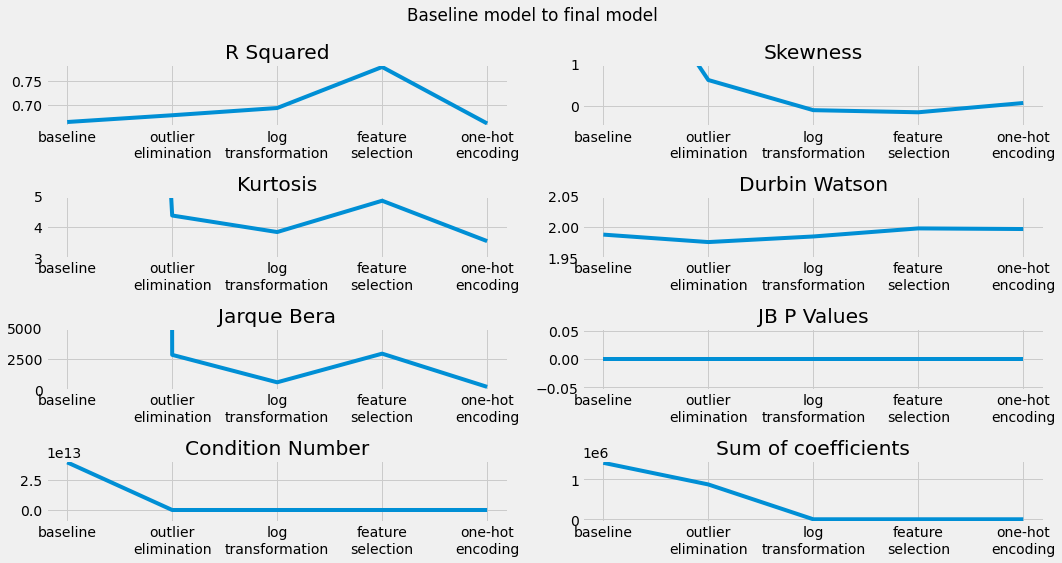

In [78]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(-.5,1.5)

plt.gcf().set_size_inches(15, 8)
fig.suptitle('Baseline model to final model')
fig.tight_layout()
plt.show()

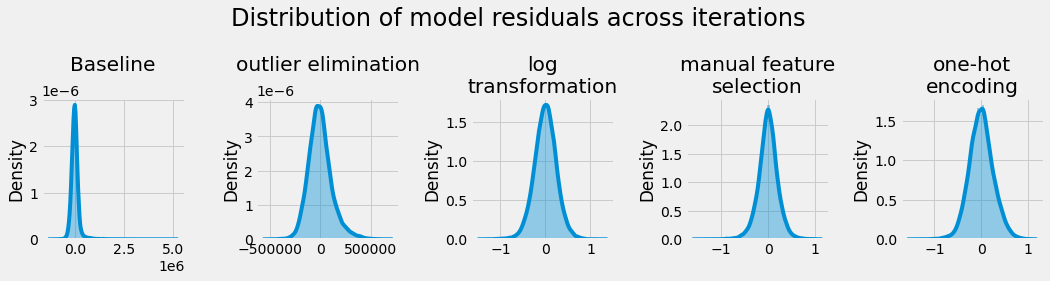

In [88]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5)

bs = sns.distplot(base_resid,ax=ax1).set_title('Baseline\n')
# axes[0,0].set_xlim(-1300000,1300000)

ot = sns.distplot(outlier_model_residual,ax=ax2).set_title('outlier elimination\n')

lm = sns.distplot(log_model_residuals,ax=ax3).set_title("log\ntransformation")

bl = sns.distplot(water_model_residuals,ax=ax4).set_title('manual feature\nselection')

lm = sns.distplot(hot_water_residuals,ax=ax5).set_title('one-hot\nencoding')

plt.gcf().set_size_inches(15, 4)
fig.suptitle("Distribution of model residuals across iterations",fontsize=24)
fig.tight_layout()
plt.show()